# Model X for Plant Disease Detection with MobileNet TFLite

This model was trained with plant leaf images from the PlantVillage Dataset belonging to 38 classes of plant health status as labels.

## Mount the Google Drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip folder to access the files
from zipfile import ZipFile
!unzip drive/MyDrive/plantvillagedataset.zip

## Import necessary libraries

In [ ]:
# Import necessary libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

## Specify the dataset directory

In [ ]:
# Specify the train and test directories
train_dir ="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
test_dir="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


# Create image processing pipeline

In [ ]:
# Using ImageDataGenerator to resize and augument images from the directory
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

# Specify image size and batch size
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32

# Create an object to parse data
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Load MobileNet model, add layers and compile the model

In [ ]:
# Import necesarry libraries
from keras.applications.mobilenet import MobileNet
from keras.models import Model
import keras
from keras import optimizers

# Load model, add layers, and specify compilers
model_finetuned = Sequential()
model_finetuned.add(MobileNet(weights='imagenet'))
model_finetuned.add(BatchNormalization())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(38, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
# Display model layers, shape and parameters
model_finetuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 38)                4902      
                                                                 
Total params: 4,390,894
Trainable params: 156,918
Non-trainable params: 4,233,976
_________________________________________________________________


## Train and fine-tune the model

In [ ]:
# Train the model with data from the image generator object
from keras.callbacks import ReduceLROnPlateau
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

# Specify the training parameters
history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=8,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Found 17572 images belonging to 38 classes.
Epoch 1/8
2197/2197 [==============================] - 1050s 473ms/step - loss: 0.7933 - accuracy: 0.7710 - val_loss: 0.4581 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 2/8
2197/2197 [==============================] - 986s 449ms/step - loss: 0.2924 - accuracy: 0.9046 - val_loss: 0.2847 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 3/8
2197/2197 [==============================] - 979s 446ms/step - loss: 0.1855 - accuracy: 0.9385 - val_loss: 0.1813 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 4/8
2197/2197 [==============================] - 982s 447ms/step - loss: 0.1330 - accuracy: 0.9553 - val_loss: 0.1381 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 5/8
2197/2197 [==============================] - 977s 445ms/step - loss: 0.1041 - accuracy: 0.9654 - val_loss: 0.0923 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 6/8
2197/2197 [==============================] - 972s 443ms/step - loss: 0.0842 - accuracy: 0.9715 - val_loss: 0.0863 - val_accuracy: 0.9722 - lr: 0.

## Save the model and make predictions

In [ ]:
# import necessary libraries
import tensorflow
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Save the trained model
model_finetuned.save('plantdiseasemobilenet8epoch.h5')

# Compile the model
model_finetuned.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Prepare the test image

1/1 [==============================] - 1s 508ms/step
[[2.96150393e-08 8.34620323e-07 7.94268544e-06 5.25011723e-09
  3.19951482e-10 3.11808217e-05 1.60831071e-10 9.98488903e-01
  2.98234721e-04 8.29398225e-04 1.13485308e-04 5.80992511e-11
  2.14585683e-07 4.43475074e-12 1.01925508e-11 5.76267345e-09
  1.80719886e-04 5.81056065e-06 1.04246783e-06 6.09352430e-11
  2.75939445e-11 6.72668301e-12 4.41102402e-14 6.62924088e-13
  1.00555475e-11 1.80892459e-06 3.13604218e-08 5.24248631e-11
  3.51847848e-05 5.67376688e-08 4.81127427e-06 1.09281206e-09
  6.32456887e-09 1.73004958e-10 2.29974134e-07 2.59425659e-09
  1.09549837e-12 6.27827532e-08]]


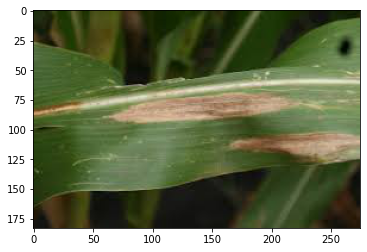

In [ ]:
img_width=224
img_height=224

# Image processing function
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

# Specify the class labels
classes=list(train_generator.class_indices.keys())

# Make prediction and display result
result = model_finetuned.predict([prepare("/content/drive/MyDrive/images (3).jpg")])
disease=image.load_img('/content/drive/MyDrive/images (3).jpg')
plt.imshow(disease)
print(result)

In [ ]:
# Display the predicted class
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


## Convert TensorFlow model to TensorFlow Lite model

In [ ]:
import tensorflow as tf

# Load the TensorFlow model
keras_model = tf.keras.models.load_model("plantdiseasemobilenet8epoch.h5")

# Convert model using the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [ ]:
# Write the model
model = converter.convert()
file = open( 'outputmobilenetof8epoch.tflite' , 'wb' ) 
file.write(model)

17439576

## Make prediction with the converted TFLite model

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="outputmobilenetof8epoch.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

[{'name': 'serving_default_mobilenet_1.00_224_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

[{'name': 'StatefulPartitionedCall:0', 'index': 106, 'shape': array([ 1, 38], dtype=int32), 'shape_signature': array([-1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Prepare the test image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
# Specify image directory
input_data = [prepare("/content/drive/MyDrive/images (5).jpg")]

In [ ]:
# Set interpreter 
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[6.26184285e-01 1.13601354e-05 6.29607603e-05 3.14450972e-02
  1.58745361e-09 2.52944355e-05 2.13320573e-06 1.07067535e-07
  1.01149863e-06 1.24904477e-06 3.15454400e-08 1.51929935e-08
  9.56769330e-09 3.59055343e-06 1.19368797e-02 4.79378421e-08
  1.01843773e-06 6.11860060e-07 3.52254148e-07 1.42691920e-06
  7.37987818e-07 4.47735656e-05 2.81213861e-08 4.99080421e-09
  4.40715064e-09 6.28911774e-04 2.65142042e-09 1.77579480e-07
  1.42036970e-06 1.55295071e-03 3.27393979e-01 8.60040095e-10
  6.81363019e-07 2.73094452e-06 8.74351172e-05 5.85822797e-12
  9.14408063e-11 6.08646136e-04]]


In [ ]:
# Display prediction
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

Apple___Apple_scab


## Visualise the training and validation accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


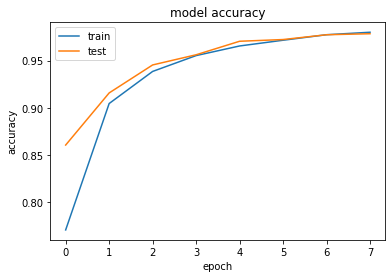

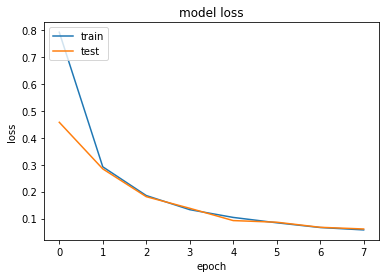

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
print(history_1.history.keys())
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()